In [ ]:
!nvidia-smi

Sat Mar  2 18:11:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Question 1
Implement and train your RNN language model on Wikitext-2 corpus using the
guidelines specified above.

a. provide a description (or illustration) of you architecture and discuss design choices,

b. list hyper-parameters used by you model and discuss how you selected these values,

c. provide learning curves of perplexity vs. epoch on the training and validation sets, and

d. provide final test set perplexity.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import itertools
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Architecture and design
### Network
**Embedding Input**
Transforms token indices into embeddings, preparing them for sequence processing.

**RNN Processing**
Processes the embedded sequence through the RNN, updating the hidden state at each timestep.

**Output Handling**
Initially, the outputs for the last timestep of each sequence are extracted using x[:, -1, :], indicating the model's prediction is based on the entire preceding sequence.
The outputs are then reshaped for the fully connected layer to make token predictions.

**Token Prediction**
Passes the last timestep's features through the fully connected layer to predict the next token.

## Design


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, params):
        super(RNNModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.RNN(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        return torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device)

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, hidden = self.rnn(x, hidden)
        x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, hidden

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                if self.params['training_shuffle']:
                    hidden = self._init_hidden(inputs.size(0))
                else:
                    hidden = self.h
                outputs, self.h = self.forward(inputs, hidden)
                self.h = self.h.detach().to(device)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()  # Convert to Python number with .item()
            train_perplexities.append(train_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}')

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()  # Convert to Python number with .item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity

In [ ]:
def replace_unk(original_dict, word_freq_threshold):
    new_dict = {}
    sum_values = 0
    words_replaced_w_unk = []
    for key, value in original_dict.items():
        if value < word_freq_threshold and key != '<unk>':
            sum_values += value
            words_replaced_w_unk.append(key)
        else:
            new_dict[key] = value
    if sum_values > 0:
        new_dict['<unk>'] = new_dict['<unk>'] + sum_values
    return new_dict, words_replaced_w_unk

In [ ]:
def read_train_data(file_name):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Count the text frequency
    word_freq = Counter(words)
    # Replace keys with small frequencies with <unk>
    new_word_freq, words_replaced_w_unk = replace_unk(word_freq, 15)
    # Convert tokens to id
    token_to_id = {"<unk>": 0}
    token_to_id.update({word: idx for idx, word in enumerate(set([word for word in new_word_freq if word != '<unk>']), start=1)})
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences, token_to_id

In [ ]:
def read_valid_test_data(file_name, token_to_id):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, text, params):
        self.data = [text[i:i + params['time_step']] for i in range(0, len(text) - params['time_step'])]
        # self.labels = [text[i + 1:i + 1 + params['time_step']] for i in range(0, len(text) - params['time_step'])]
        self.labels = [text[i + params['time_step']] for i in range(0, len(text) - params['time_step'])]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
def load_data(params):
    # Read data into id sequences
    train_data, token_to_id = read_train_data('wiki2.train.txt')
    valid_data = read_valid_test_data('wiki2.valid.txt', token_to_id)
    test_data = read_valid_test_data('wiki2.test.txt', token_to_id)

    # Create dataset instances
    train_dataset = CustomDataset(train_data, params)
    valid_dataset = CustomDataset(valid_data, params)
    test_dataset = CustomDataset(test_data, params)

    # Load dataset
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=params['training_shuffle'], num_workers=12, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=12, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=12, pin_memory=True)
    return train_loader, valid_loader, test_loader, token_to_id

## Hyper parameter

### Fixed parameters

**batch_size**: 1024

A trade-off between training speed and training resources, we pick 1024 as batch_size.

**epoch**: 20

It is required we train 20 epochs.

**num_rnn_layer**: 1

For question 1, we start with 1 rnn layer and will experiment with 2 or more layers in question 2.

**dropout**: 0,

Dropout is designed to prevent overfitting between the different layers of the network. It should only be applied when there are multiple layers (num_layers > 1) because it's meant to act between these layers. If we only have one layer (num_layers=1), there's nowhere for the dropout to be applied in the way it's intended in these models.

**weight_decay**: False

For question 1, we do not add weight decay for now as we do not know whether the language model is prone to overfitting yet. We will experiment with weight deday in question 2.

**clip_value**: False

For question 1, we do not add gradient clipping for now as we have not observed vanishing or exploding gradient yet. We will experiment with gradient clipping in question 2.


### More experiments

**time_step**: 10, (10, 20, 30)

As we can pick time step ranging from 10 to 30. We will do experiments on three values (10, 20, 30) to see the difference.

**embedding_dim**: 100, (100, 300)

Common dimensions for word embeddings include below. The choice of dimensionality depends on the specific network, the size and complexity of the dataset, and the computational resources available. Higher dimensions can capture more detailed semantics but require more computational power and data to train effectively. Since we should start from 100 dimensions and we do not have a complex network like transformer, we pick 100 and 300 to experiment.

- 50 dimensions: Often used for smaller datasets where the linguistic complexity is lower. This smaller dimension can capture basic semantic relationships with less computational cost.
- 100 dimensions: This is a middle-ground choice, balancing between capturing sufficient semantic detail and maintaining manageable computational requirements.
- 300 dimensions: This is one of the most common dimensions used, especially in models like Word2Vec or GloVe trained on large text corpora. It offers a good balance between detailed semantic capture and computational efficiency.
- 768 dimensions: Embeddings like those from BERT (a transformer-based model) use this size, offering very detailed representations of word meanings based on broader contexts.
- 1024 dimensions and beyond: Used in even larger and more complex models such as GPT-3 and newer versions of BERT, these higher-dimensional embeddings can capture nuanced meanings and relationships but at the cost of increased computational resources.

**hidden_dim**: 100, (100, 200, 500)

The hidden state size does not have to be equal to the input size.
The hidden state size in RNNs determines the capacity of the network to capture information from past inputs. There is no one-size-fits-all answer, but here are common practices:

- Small Datasets and Simpler Problems: Typically consists of a few hundred to a few thousand samples. Hidden state sizes can range from 50 to 200 units. Smaller hidden states reduce the risk of overfitting on limited data.
- Medium to Large Datasets: Count: Ranges from tens of thousands to a few hundred thousand samples. For tabular data, this might be between 10,000 and 500,000 records. Hidden state sizes can range from 200 to 600 units. Larger hidden states can capture more information and nuances from the input sequences.
- Very Complex Tasks: In tasks like large-scale language modeling or sequence-to-sequence models, hidden state sizes can be even larger, ranging from 600 to 2000 units or more, depending on computational resources and the specific requirements of the task.

**learning_rate**: 0.001, (0.001, 0.01)

A typical starting learning rate for RNNs can range from 0.001 to 0.01. This range is broad enough to encompass different scenarios from slow, careful learning to more aggressive updates.  We will do experiments on two values (0.001, 0.01) to see the difference.

**training_shuffle**: True, (True, False)

This choice will affect whether we carry over hidden state from one batch to the next:

If we shuffle the training data, we disrupt the natural sequence order of continuous text or stories. In such cases, we will not carry over the hidden state from one batch to the next, as each batch does not sequentially follow the previous one. Initializing hidden state at the beginning of each batch ensures that the model treats each batch (or sequence within a batch) independently, without inappropriate context from unrelated text sequences.

If we do not shuffle training data and the sequences form part of a continuous text, carrying over the hidden state from one batch to the next during training can be beneficial. This helps the model maintain context across different parts of the text, improving its ability to learn dependencies and predict subsequent words more accurately.

Since we have limited computing resources, we will not run grid_search. Instead, we will compare paramters separately.

In [ ]:
def grid_search():
    params = {
        'batch_size': None,
        'time_step': None,
        'embedding_dim': None,
        'hidden_dim': None,
        'num_rnn_layer': None,
        'dropout': None,
        'epoch': None,
        'learning_rate': None,
        'training_shuffle': None,
        'weight_decay': None,
        'clip_value': None,}
    batch_size = [1024]
    time_step = [10, 20, 30]
    embedding_dim = [100, 300]
    hidden_dim = [100, 200, 500]
    num_rnn_layer = [1]
    dropout = [0]
    epoch = [20]
    learning_rate = [0.0001, 0.001]
    training_shuffle = [True, False]
    weight_decay = [False]
    clip_value = [False]
    param_combinations = list(itertools.product(batch_size, time_step, embedding_dim, hidden_dim, num_rnn_layer, dropout, epoch, learning_rate, training_shuffle, weight_decay, clip_value))
    grid_search_data = []
    for combo in param_combinations:
        keys = list(params.keys())
        params_update = dict(zip(keys, combo))
        params.update(params_update)
        model = RNNModel(params).to(device)
        model.train()
        _, params['perplexity'] = model.test()
        print (params)
        grid_search_data.append(params.copy())
    df = pd.DataFrame(grid_search_data)
    df.to_csv('grid_search.csv', index=True)
    return df

We start with this initial parameters and further start experiments.

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': False,
    'clip_value': False
}

In [ ]:
model = RNNModel(params)
model.to(device)

2039 213 240


Epoch 1/20, Train Loss: 5.5997, Train Perplexity: 270.3459
Epoch 1/20, Validation Loss: 5.1308, Validation Perplexity: 169.1478
Epoch 2/20, Train Loss: 5.0709, Train Perplexity: 159.3185
Epoch 2/20, Validation Loss: 4.9731, Validation Perplexity: 144.4693
Epoch 3/20, Train Loss: 4.8897, Train Perplexity: 132.9089
Epoch 3/20, Validation Loss: 4.9044, Validation Perplexity: 134.8854
Epoch 4/20, Train Loss: 4.7746, Train Perplexity: 118.4596
Epoch 4/20, Validation Loss: 4.8558, Validation Perplexity: 128.4829
Epoch 5/20, Train Loss: 4.6893, Train Perplexity: 108.7769
Epoch 5/20, Validation Loss: 4.8306, Validation Perplexity: 125.2905
Epoch 6/20, Train Loss: 4.6220, Train Perplexity: 101.6935
Epoch 6/20, Validation Loss: 4.8086, Validation Perplexity: 122.5561
Epoch 7/20, Train Loss: 4.5678, Train Perplexity: 96.3299
Epoch 7/20, Validation Loss: 4.7973, Validation Perplexity: 121.1809
Epoch 8/20, Train Loss: 4.5223, Train Perplexity: 92.0443
Epoch 8/20, Validation Loss: 4.7847, Validation

(4.744749836126963, tensor(114.9791))

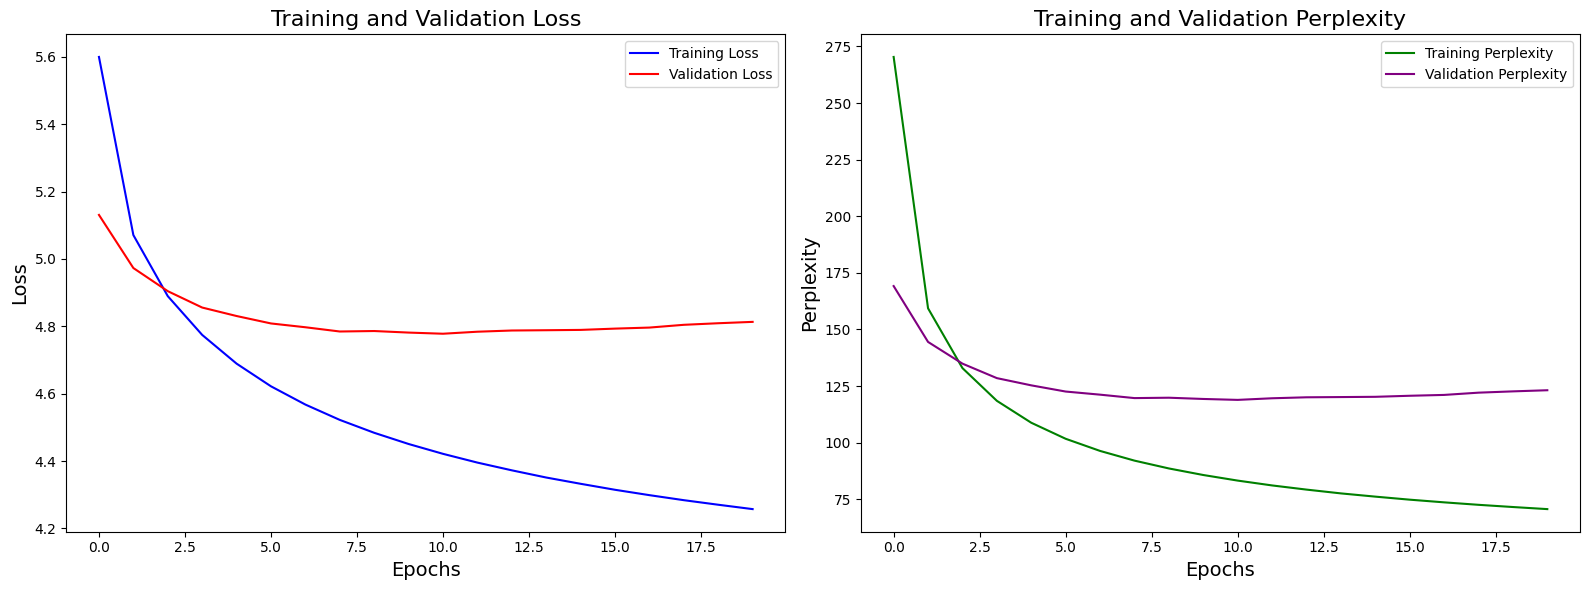

In [ ]:
model.train()
model.test()

## Time step
10, 20, 30

First, we increase time step from 10 to 20 and 30.


In [ ]:
params = {
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 8192,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params)
model.to(device)
model.train()
model.test()

254 27 30
Epoch 1/20, Train Loss: 6.4174, Train Perplexity: 612.4344
Epoch 1/20, Validation Loss: 5.7949, Validation Perplexity: 328.6038
Epoch 2/20, Train Loss: 5.7621, Train Perplexity: 318.0205
Epoch 2/20, Validation Loss: 5.5022, Validation Perplexity: 245.2244
Epoch 3/20, Train Loss: 5.4948, Train Perplexity: 243.4193
Epoch 3/20, Validation Loss: 5.3177, Validation Perplexity: 203.9214
Epoch 4/20, Train Loss: 5.3211, Train Perplexity: 204.6032
Epoch 4/20, Validation Loss: 5.2029, Validation Perplexity: 181.8048


KeyboardInterrupt: 

In [ ]:
params = {
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

## embedding_dim
100, 300
We increase word embedding size from 100 to 300.

In [ ]:
params = {
    'embedding_dim': 300,
    'time_step': 30,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

## hidden_dim
100, 200, 500

We increase hidden state size from 100 to 200 and 500.

In [ ]:
params = {
    'hidden_dim': 200,
    'embedding_dim': 100,
    'time_step': 10,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

In [ ]:
params = {
    'hidden_dim': 500,
    'embedding_dim': 300,
    'time_step': 30,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

## learning_rate
We increase learning_rate from 0.001 to 0.01.

In [ ]:
params = {
    'learning_rate': 0.01,
    'hidden_dim': 500,
    'embedding_dim': 300,
    'time_step': 30,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

## Training shuffle
Change to not shuffling training data and pass on the hidden state to the next batch.

In [ ]:
params = {
    'training_shuffle': False,
    'learning_rate': 0.001,
    'hidden_dim': 500,
    'embedding_dim': 100,
    'time_step': 10,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

# Question 2:
Discuss how you might improve this “vanilla” RNN language modeling
architecture.

- **Regularization Techniques:**
    - **Weight Regularization**: Adding L1 or L2 regularization to the weights can also help in preventing overfitting.
      - As we can see from above, there is overfitting problem. We will use L2 weight decay to minimize the overfitting.
- **Optimization and Training Techniques:**
    - **Gradient Clipping**: This is crucial for preventing the exploding gradient problem in RNNs. It limits the size of the gradients during backpropagation to ensure stable training.
      - We will implement Gradient Clipping
- **Architectural Tweaks:**
    - **Stacked RNN Layers**: Increase the model's capacity by adding more layers. However, be mindful of the increased computational cost and the potential for overfitting.
      - We will use 2 layers to compare the result.
- **Advanced RNN Architectures:**
    - **LSTM and GRU**: Vanilla RNNs suffer from vanishing and exploding gradient problems, making them less effective for learning long-term dependencies. Long Short-Term Memory (LSTM) units or Gated Recurrent Units (GRU) are more sophisticated variants that can capture long-range dependencies better, improving the model's performance on tasks requiring understanding of longer context.
      - We will change the current structure to LSTM.
    - **Bidirectional RNNs**: These process the data in both forward and backward directions, providing a richer representation of the context which can improve the model's understanding and predictions.
- **Embedding Layer Improvements:**
    - **Pre-trained Word Embeddings**: Instead of learning word embeddings from scratch, use pre-trained embeddings like GloVe or Word2Vec. These can provide a good starting point and add external knowledge to your model.
      - Since it needs extra pretrained model here, we will not implement this one.

# Question 3
Implement one (or more) of the improvements mentioned above, and
provide a new set of learning curves and final test perplexity.

## 1. add L2 weight decay

As we can see from above, there is overfitting problem. After we use L2 weight decay to minimize the overfitting, it significantly reduced the overfitting problem.

2039 213 240
Epoch 1/20, Train Loss: 5.6933, Train Perplexity: 296.8576
Epoch 1/20, Validation Loss: 5.2293, Validation Perplexity: 186.6563
Epoch 2/20, Train Loss: 5.2082, Train Perplexity: 182.7731
Epoch 2/20, Validation Loss: 5.0331, Validation Perplexity: 153.4073
Epoch 3/20, Train Loss: 5.0688, Train Perplexity: 158.9839
Epoch 3/20, Validation Loss: 4.9571, Validation Perplexity: 142.1757
Epoch 4/20, Train Loss: 4.9958, Train Perplexity: 147.7975
Epoch 4/20, Validation Loss: 4.9124, Validation Perplexity: 135.9689
Epoch 5/20, Train Loss: 4.9530, Train Perplexity: 141.6028
Epoch 5/20, Validation Loss: 4.8873, Validation Perplexity: 132.5993
Epoch 6/20, Train Loss: 4.9246, Train Perplexity: 137.6327
Epoch 6/20, Validation Loss: 4.8672, Validation Perplexity: 129.9531
Epoch 7/20, Train Loss: 4.9038, Train Perplexity: 134.8033
Epoch 7/20, Validation Loss: 4.8565, Validation Perplexity: 128.5715
Epoch 8/20, Train Loss: 4.8872, Train Perplexity: 132.5879
Epoch 8/20, Validation Loss: 4.8

(4.725079292058945, tensor(112.7394))

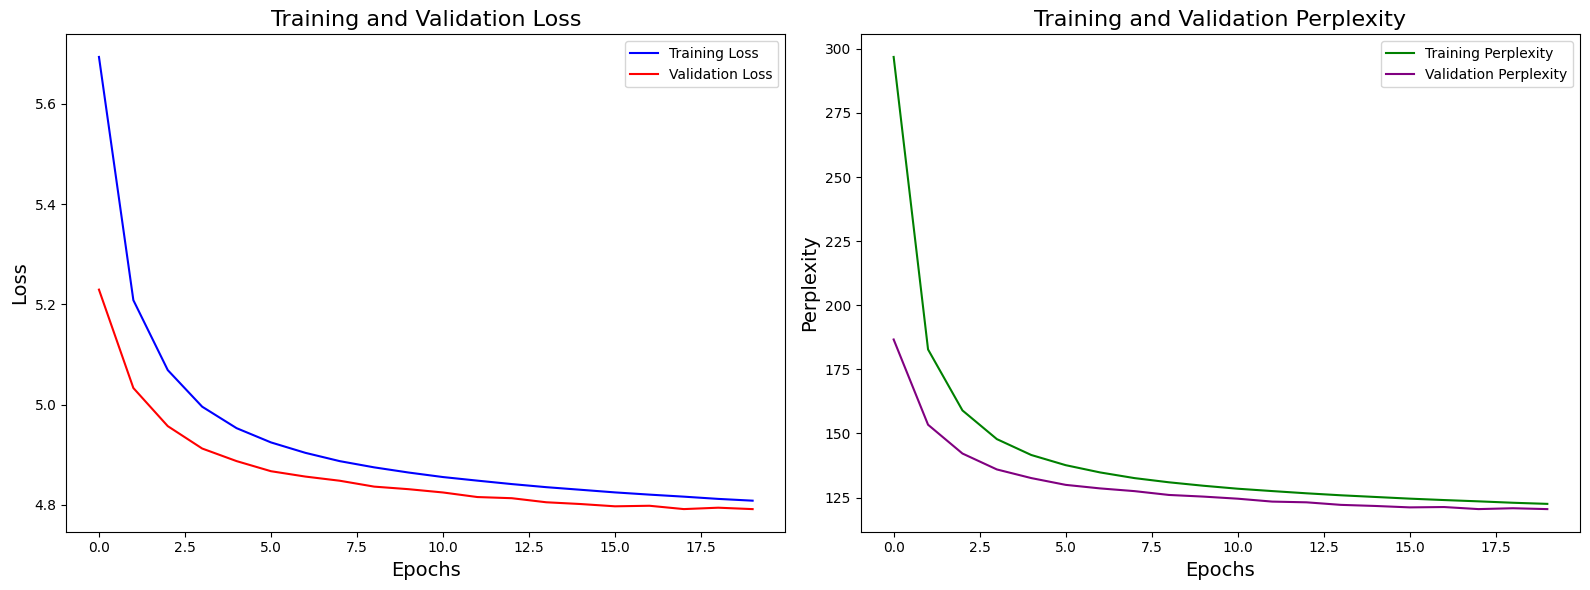

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

## 2. add Gradient Clipping

Recurrent Neural Networks (RNNs) are particularly prone to the exploding gradient problem due to their inherent structure and the way they learn temporal dependencies from data. This susceptibility is primarily due to the repeated multiplication of gradients through time during the backpropagation through time (BPTT) process, which is used to train RNNs. In RNNs, the hidden state at each timestep is a function of the previous hidden state and the current input. This recurrence relation means that the hidden state is effectively a product of all previous hidden states and inputs. During backpropagation, this leads to gradients being multiplied through each timestep.

Gradient Clipping limits the size of the gradients during backpropagation to ensure stable training. However, since we have not met with exploding gradients so far, it is not that effective in increasing performance.

2039 213 240
Epoch 1/20, Train Loss: 5.6923, Train Perplexity: 296.5695
Epoch 1/20, Validation Loss: 5.2186, Validation Perplexity: 184.6838
Epoch 2/20, Train Loss: 5.2056, Train Perplexity: 182.2867
Epoch 2/20, Validation Loss: 5.0328, Validation Perplexity: 153.3572
Epoch 3/20, Train Loss: 5.0670, Train Perplexity: 158.7052
Epoch 3/20, Validation Loss: 4.9544, Validation Perplexity: 141.7932
Epoch 4/20, Train Loss: 4.9951, Train Perplexity: 147.6917
Epoch 4/20, Validation Loss: 4.9144, Validation Perplexity: 136.2315
Epoch 5/20, Train Loss: 4.9523, Train Perplexity: 141.5008
Epoch 5/20, Validation Loss: 4.8908, Validation Perplexity: 133.0556
Epoch 6/20, Train Loss: 4.9240, Train Perplexity: 137.5466
Epoch 6/20, Validation Loss: 4.8678, Validation Perplexity: 130.0351
Epoch 7/20, Train Loss: 4.9027, Train Perplexity: 134.6581
Epoch 7/20, Validation Loss: 4.8541, Validation Perplexity: 128.2663
Epoch 8/20, Train Loss: 4.8862, Train Perplexity: 132.4559
Epoch 8/20, Validation Loss: 4.8

(4.726715404788653, tensor(112.9241))

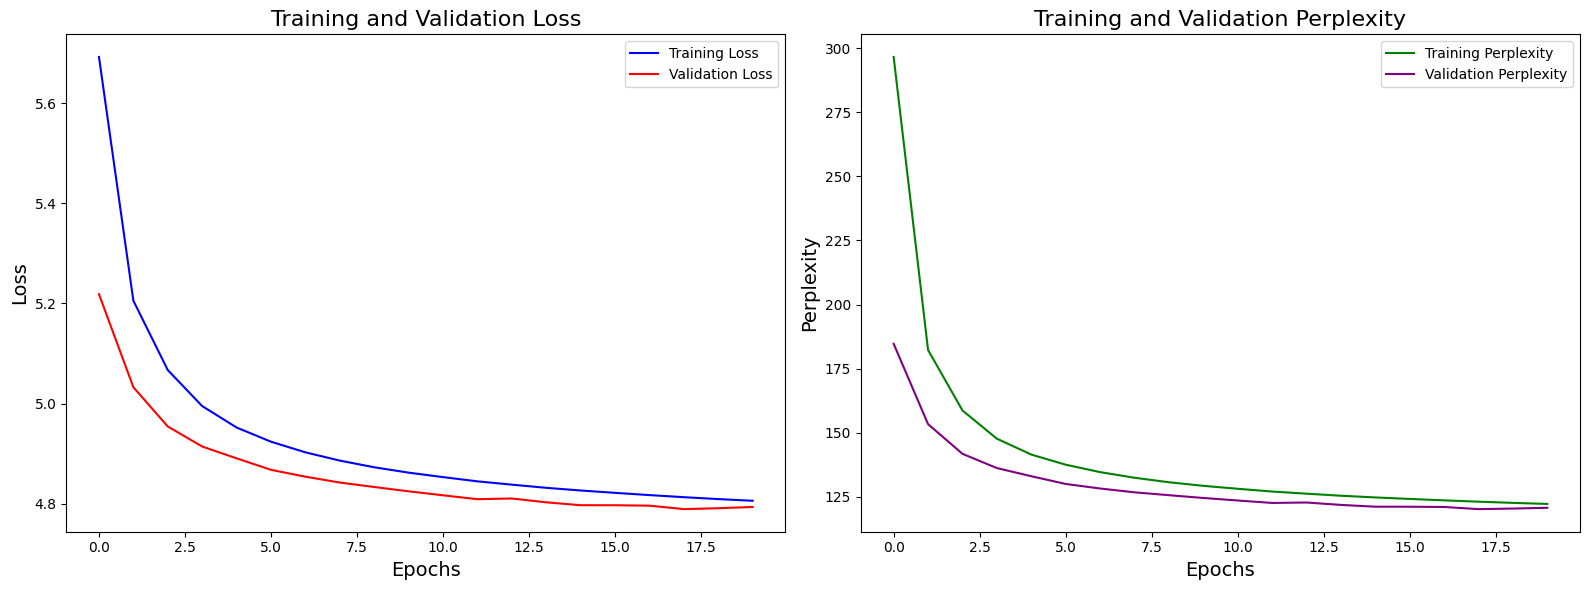

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 1
}
model = RNNModel(params).to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.7048, Train Perplexity: 300.2923
Epoch 1/20, Validation Loss: 5.2320, Validation Perplexity: 187.1758
Epoch 2/20, Train Loss: 5.2122, Train Perplexity: 183.5010
Epoch 2/20, Validation Loss: 5.0353, Validation Perplexity: 153.7473
Epoch 3/20, Train Loss: 5.0735, Train Perplexity: 159.7334
Epoch 3/20, Validation Loss: 4.9616, Validation Perplexity: 142.8253
Epoch 4/20, Train Loss: 5.0014, Train Perplexity: 148.6153
Epoch 4/20, Validation Loss: 4.9128, Validation Perplexity: 136.0258
Epoch 5/20, Train Loss: 4.9552, Train Perplexity: 141.9111
Epoch 5/20, Validation Loss: 4.8950, Validation Perplexity: 133.6234
Epoch 6/20, Train Loss: 4.9246, Train Perplexity: 137.6391
Epoch 6/20, Validation Loss: 4.8729, Validation Perplexity: 130.6990
Epoch 7/20, Train Loss: 4.9026, Train Perplexity: 134.6356
Epoch 7/20, Validation Loss: 4.8543, Validation Perplexity: 128.2854
Epoch 8/20, Train Loss: 4.8861, Train Perplexity: 132.4311
Epoch 8/20, Validation Loss: 4.8

(4.714305059115092, tensor(111.5313))

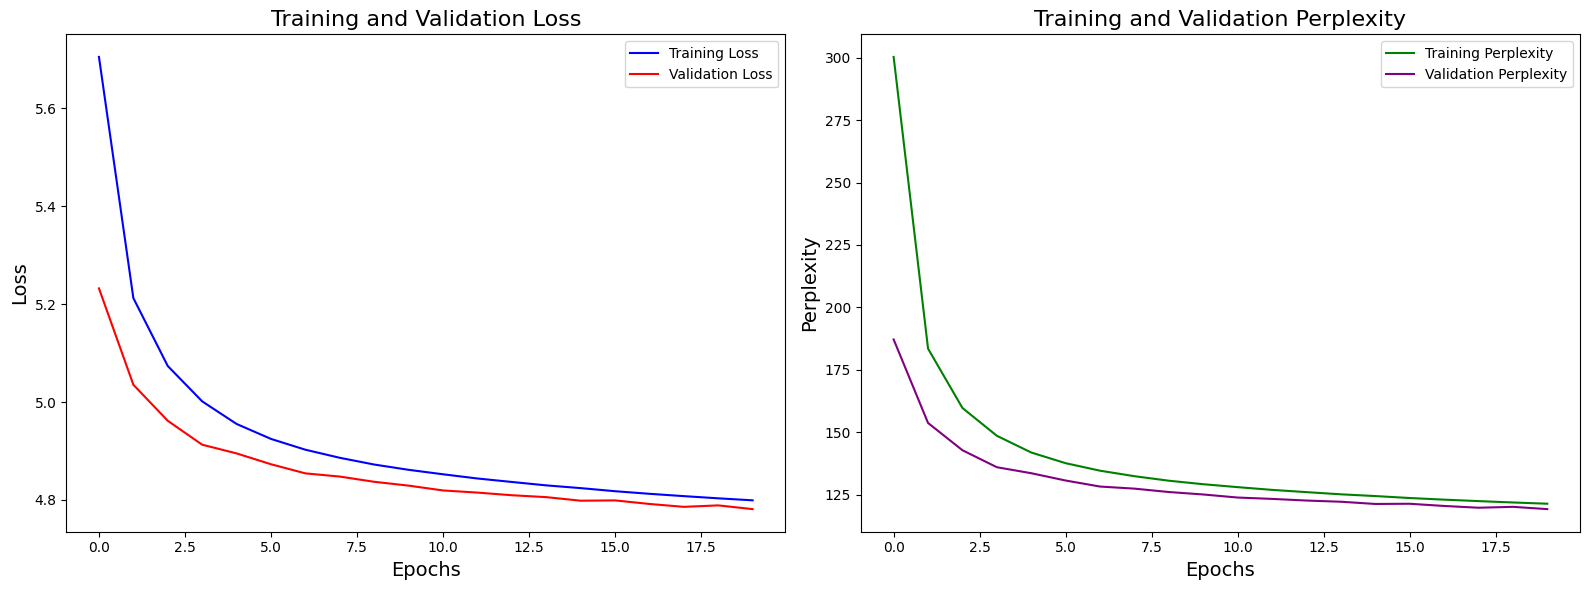

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

## 3. add RNN layers
Increase the model's capacity by adding more layers. Here, we will increase from 1 RNN layer to 2 layers. However, we should be be mindful of the increased computational cost and the potential for overfitting. Therefore, we will try no dropout and with dropout.

### 3.1 No dropout
rnn_layers=2, dropout=0

2039 213 240
Epoch 1/20, Train Loss: 5.7045, Train Perplexity: 300.2031
Epoch 1/20, Validation Loss: 5.2099, Validation Perplexity: 183.0835
Epoch 2/20, Train Loss: 5.1668, Train Perplexity: 175.3553
Epoch 2/20, Validation Loss: 4.9828, Validation Perplexity: 145.8831
Epoch 3/20, Train Loss: 5.0117, Train Perplexity: 150.1618
Epoch 3/20, Validation Loss: 4.9158, Validation Perplexity: 136.4293
Epoch 4/20, Train Loss: 4.9331, Train Perplexity: 138.8035
Epoch 4/20, Validation Loss: 4.8652, Validation Perplexity: 129.6911
Epoch 5/20, Train Loss: 4.8842, Train Perplexity: 132.1877
Epoch 5/20, Validation Loss: 4.8328, Validation Perplexity: 125.5570
Epoch 6/20, Train Loss: 4.8506, Train Perplexity: 127.8115
Epoch 6/20, Validation Loss: 4.8129, Validation Perplexity: 123.0823
Epoch 7/20, Train Loss: 4.8264, Train Perplexity: 124.7572
Epoch 7/20, Validation Loss: 4.7993, Validation Perplexity: 121.4242
Epoch 8/20, Train Loss: 4.8066, Train Perplexity: 122.3111
Epoch 8/20, Validation Loss: 4.7

(4.631499575575193, tensor(102.6679))

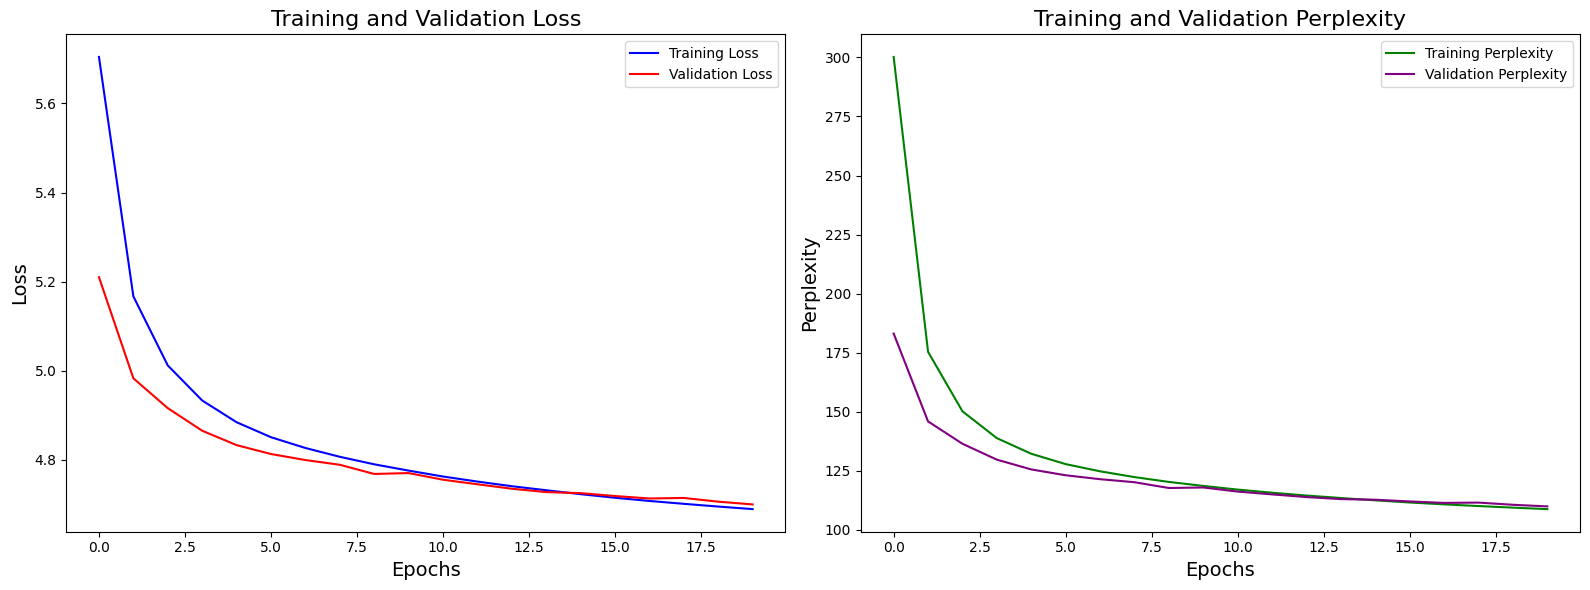

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

### 3.2 with dropout
rnn_layers=2, dropout=0.3

1019 107 120
Epoch 1/20, Train Loss: 5.9578, Train Perplexity: 386.7610
Epoch 1/20, Validation Loss: 5.4335, Validation Perplexity: 228.9383
Epoch 2/20, Train Loss: 5.4195, Train Perplexity: 225.7669
Epoch 2/20, Validation Loss: 5.1906, Validation Perplexity: 179.5809
Epoch 3/20, Train Loss: 5.2122, Train Perplexity: 183.4975
Epoch 3/20, Validation Loss: 5.0578, Validation Perplexity: 157.2499
Epoch 4/20, Train Loss: 5.1006, Train Perplexity: 164.1265
Epoch 4/20, Validation Loss: 4.9950, Validation Perplexity: 147.6774
Epoch 5/20, Train Loss: 5.0341, Train Perplexity: 153.5665
Epoch 5/20, Validation Loss: 4.9518, Validation Perplexity: 141.4257
Epoch 6/20, Train Loss: 4.9872, Train Perplexity: 146.5303
Epoch 6/20, Validation Loss: 4.9221, Validation Perplexity: 137.2931
Epoch 7/20, Train Loss: 4.9530, Train Perplexity: 141.5961
Epoch 7/20, Validation Loss: 4.8987, Validation Perplexity: 134.1170
Epoch 8/20, Train Loss: 4.9263, Train Perplexity: 137.8661
Epoch 8/20, Validation Loss: 4.8

(4.735064359505971, tensor(113.8708))

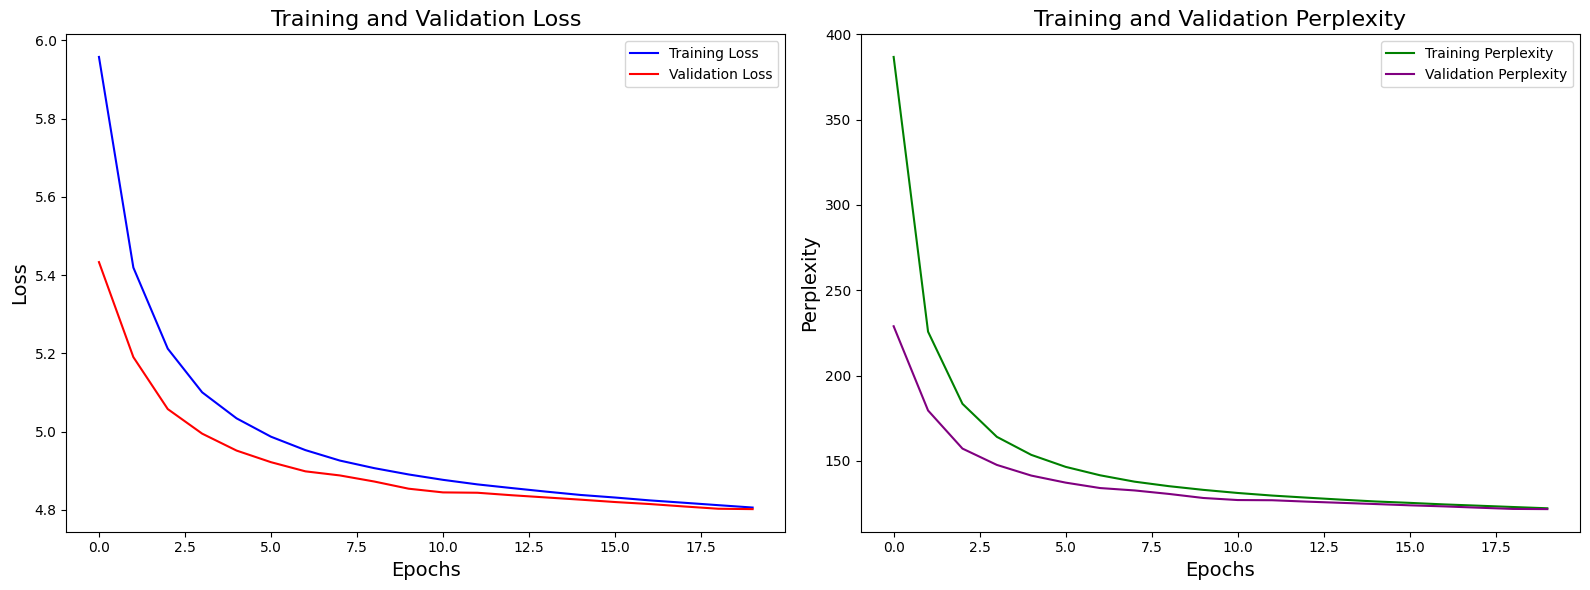

In [ ]:
params = {
    'batch_size': 2048,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0.3,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

## 4. LSTM

By switching from RNN to LSTM, the model can potentially capture longer dependencies and mitigate issues like vanishing gradients. This could lead to improved performance, especially on tasks requiring understanding of long-term context.
After changing to LSTM, monitor the model's performance and training dynamics. You may need to adjust hyperparameters, such as learning rate or the number of layers.
Since LSTMs are more parameter-heavy than vanilla RNNs, be aware of increased computational requirements. Monitor memory usage and training time, and adjust the batch size if necessary.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, params):
        super(LSTMModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.LSTM(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        # Initialize both the hidden and cell states
        return (torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device),
            torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device))

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, (hidden, cell) = self.rnn(x, hidden)
        x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, (hidden, cell)

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                if self.params['training_shuffle']:
                    hidden = self._init_hidden(inputs.size(0))
                else:
                    hidden = (self.h[0].detach(), self.h[1].detach())
                outputs, self.h = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()  # Convert to Python number with .item()
            train_perplexities.append(train_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}')

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()  # Convert to Python number with .item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity